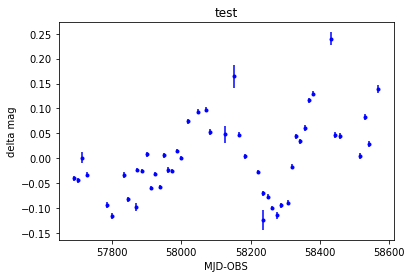

In [6]:
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), magerr_ref1[mask],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [7]:
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = np.array(magerr_ref1[mask], dtype=float)
n=len(x)
X = np.reshape(x,(n,1))

In [8]:
X_new,muJ,sdJ = np.loadtxt('Jband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
XK_new,muK,sdK = np.loadtxt('Kband.txt', delimiter=',', usecols=(0,1,2), unpack=True)

In [62]:
#Define simple planck function
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 1.0#8*np.pi*h*c**2#2.0*h*c**2
    b = h*c/(1e-9*wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity/np.max(intensity)
def transferDT(x,mu,sigma,A_T,wav,T):
    '''Defines the transfer function for the DT'''
    BB = planck(wav, T)
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = A_T/(x*sigma*np.sqrt(2*np.pi))
    return BB*front*np.exp(exp)
#might need to include a normalization here
#can you determine the index of the power law? Maybe by a fit in a filter?
def power(wav,wav_0,K_0,index):
    powr=K_0*(wav/wav_0)**(index)
    return powr
def transferAD(x,mu,sigma,A_T,wav,wav_0,K_0,index):
    '''Defines the transfer function for the AD'''
    powr = power(wav, wav_0, K_0, index)
    
    mu_max = 7.0
    sigma_max=3.5
    exp_max = -((np.log(x)-mu_max)**2/(2*sigma_max**2)) 
    A_T_max=0.0
    front_max = (1.0-A_T_max)/(x*sigma_max*np.sqrt(2*np.pi))
    AD_max = front_max*np.exp(exp_max)
    
    exp = -((np.log(x)-mu)**2/(2*sigma**2))
    front = (1.0-A_T)/(x*sigma*np.sqrt(2*np.pi))
    return powr*front*np.exp(exp)/AD_max
def transfertot(x,mu_DT,mu_AD,sigma_DT,sigma_AD,A_T,T,wav,wav_0, K_0,index):
    transfer_DT = transferDT(x,mu_DT,sigma_DT,A_T,wav,T)
    transfer_AD = transferAD(x,mu_AD,sigma_AD,A_T,wav,wav_0,K_0,index)
    return transfer_DT + transfer_AD

In [63]:
sigma_DT_val=3.5#.00.04
sigma_AD_val=3.5#0.04
mu_DT_val=7.0
mu_AD_val=7.0#11.0
A_T_val=0.5
T_val=2000.0
wav_val=5000.0#10.0
wav_0_val=5000.0#100.0
K_0_val=5.0
index_val=-5.0

In [64]:
from scipy import signal
a=[0.05,0.05,0.05]
b=[0.05,0.05,0.05]
print(np.convolve(a,b,'same'))
print(signal.convolve(a, b, mode='same'))

[0.005  0.0075 0.005 ]
[0.005  0.0075 0.005 ]


In [65]:
np.log(x)-7.0

array([3.96284184, 3.96304784, 3.96325667, 3.96348129, 3.96449034,
       3.96473259, 3.96535538, 3.96556065, 3.96596098, 3.96599496,
       3.9662539 , 3.96649503, 3.96670169, 3.96690648, 3.96711473,
       3.96732141, 3.9675451 , 3.96775154, 3.96797496, 3.96820353,
       3.9685126 , 3.9690119 , 3.96943977, 3.96964648, 3.97039164,
       3.9708033 , 3.97106188, 3.97135405, 3.97202398, 3.97226549,
       3.97228261, 3.97250522, 3.97272776, 3.9729519 , 3.97317282,
       3.97348057, 3.97370246, 3.97390809, 3.9741132 , 3.97431829,
       3.97452875, 3.9747336 , 3.97563804, 3.97584228, 3.97606483,
       3.97707853, 3.97728337, 3.97748854, 3.97796732])

In [66]:
planck(wav_val, T_val)

1.0

In [67]:
transferDT(X,mu_DT_val,sigma_DT_val,A_T_val,wav_val,T_val)

array([[5.20396495e-07],
       [5.20254629e-07],
       [5.20110860e-07],
       [5.19956254e-07],
       [5.19262279e-07],
       [5.19095807e-07],
       [5.18668055e-07],
       [5.18527140e-07],
       [5.18252431e-07],
       [5.18229121e-07],
       [5.18051516e-07],
       [5.17886178e-07],
       [5.17744515e-07],
       [5.17604165e-07],
       [5.17461492e-07],
       [5.17319927e-07],
       [5.17166751e-07],
       [5.17025424e-07],
       [5.16872518e-07],
       [5.16716131e-07],
       [5.16504735e-07],
       [5.16163409e-07],
       [5.15871084e-07],
       [5.15729912e-07],
       [5.15221317e-07],
       [5.14940545e-07],
       [5.14764260e-07],
       [5.14565145e-07],
       [5.14108858e-07],
       [5.13944463e-07],
       [5.13932812e-07],
       [5.13781325e-07],
       [5.13629934e-07],
       [5.13477498e-07],
       [5.13327289e-07],
       [5.13118114e-07],
       [5.12967345e-07],
       [5.12827669e-07],
       [5.12688378e-07],
       [5.12549138e-07],


In [68]:
power(wav_val,wav_0_val,K_0_val,index_val)

5.0

In [69]:
transferAD(X,mu_AD_val,sigma_AD_val,A_T_val,wav_val,wav_0_val,K_0_val,index_val)

array([[2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5],
       [2.5]])

In [21]:
wav=1449.0
T=2000.0
wav_peak=2.898*1e6/T
print(wav_peak)
b = h*c/(1e-9*wav_peak*k*T)
intensity = 1.0/( (wav_peak**5) * (np.exp(b) - 1.0) )
print(intensity)


1449.0
1.0940723501371404e-18


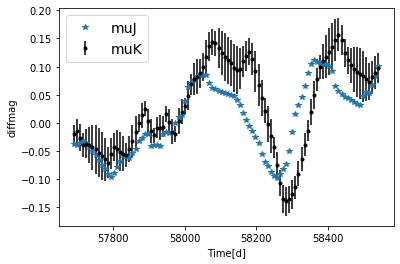

In [43]:
#conv = Psitot(soln.x, XK_new, muK, muJ, sdK)

plt.errorbar(XK_new, muK, yerr=sdK, fmt=".k", capsize=0, label='muK')
#plt.plot(XK_new, 1e82*conv, ":r", label="1e82*ML")
plt.plot(XK_new, muJ, '*', label="muJ")
plt.legend(fontsize=14)
#plt.xlim(58240,58290)
plt.xlabel("Time[d]")
plt.ylabel("diffmag");

In [59]:
wav_0=5000.0
sigma_DT=3.925736
sigma_AD=np.log(300.0)
mu_DT= 4.654890
mu_AD=np.log(300.0)
A_T=0.486334
wav= 9933.279485
T=7.250991
K_0=5.202828
index=0.287942
    
powr = K_0*(wav/wav_0)**(index)
exp_AD = -((np.log(XK_new)-mu_AD)**2/(2*sigma_AD**2))
front_AD = (1.0-A_T)/(XK_new*sigma_AD)
Psi_AD = 57690.160596*powr*front_AD*np.exp(exp_AD)

print(Psi_AD)

[0.37324491 0.3731803  0.37311572 0.37305115 0.3729866  0.37292208
 0.37285757 0.37279308 0.37272862 0.37266418 0.37259975 0.37253535
 0.37247096 0.3724066  0.37234226 0.37227794 0.37221364 0.37214936
 0.3720851  0.37202086 0.37195664 0.37189244 0.37182826 0.3717641
 0.37169996 0.37163584 0.37157175 0.37150767 0.37144361 0.37137957
 0.37131556 0.37125156 0.37118759 0.37112363 0.3710597  0.37099578
 0.37093189 0.37086801 0.37080416 0.37074032 0.37067651 0.37061272
 0.37054894 0.37048519 0.37042145 0.37035774 0.37029405 0.37023038
 0.37016672 0.37010309 0.37003948 0.36997589 0.36991231 0.36984876
 0.36978523 0.36972172 0.36965822 0.36959475 0.3695313  0.36946787
 0.36940446 0.36934106 0.36927769 0.36921434 0.36915101 0.3690877
 0.3690244  0.36896113 0.36889788 0.36883465 0.36877143 0.36870824
 0.36864507 0.36858192 0.36851878 0.36845567 0.36839258 0.3683295
 0.36826645 0.36820342 0.3681404  0.36807741 0.36801443 0.36795148
 0.36788854 0.36782563 0.36776274 0.36769986 0.367637   0.3675741

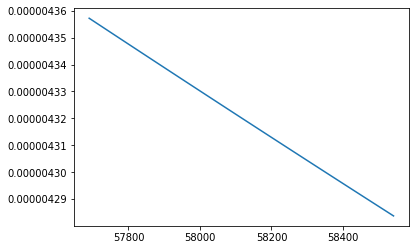

In [57]:
plt.plot(XK_new,powr*front_AD*np.exp(exp_AD))

C:\Users\Ejer\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Ejer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Ejer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


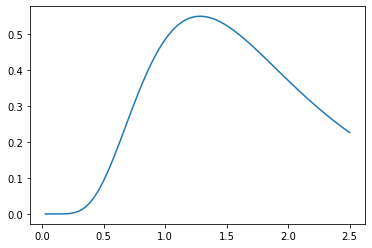

In [58]:
sig=0.5
mean=0.5
x=np.linspace(0,2.5,100)
front=1/(x*sig*np.sqrt(2*np.pi))
y=front*np.exp(-(np.log(x)-mean)**2/(2*sig**2))
ynorm=y/((1/(np.exp(mean-sig**2)*sig*np.sqrt(2*np.pi)))*np.exp(-(np.log(np.exp(mean-sig**2))-mean)**2/(2*sig**2)))
plt.plot(x,y)